# San Francisco Crime Classification

<img src='https://raw.githubusercontent.com/xu-hong/sfpd-crime/master/crime_map.png'>

Image Credit: [gwintrob](https://github.com/gwintrob/crime-doesnt-climb/blob/master/README.md)

From 1934 to 1963, San Francisco was infamous for housing some of the world's most notorious criminals on the inescapable island of Alcatraz.

Today, the city is known more for its tech scene than its criminal past. But, with rising wealth inequality, housing shortages, and a proliferation of expensive digital toys riding BART to work, there is no scarcity of crime in the city by the bay.

From Sunset to SOMA, and Marina to Excelsior, SFPD Crime Incident Reporting system, which is updated daily, provides nearly 12 years of crime reports from across all of San Francisco's neighborhoods.


Questions to ask:
- How are differenct types of crimes distributed across the city? Aretheir patterns different spatially or temporally?
- Can we predict the category of crimes that occurred in the city, given information like time and location?


A crime type [mapping visualization](http://nbviewer.jupyter.org/github/xu-hong/sfpd-crime/blob/master/SFPD_Crime_Mapping.ipynb) is also created as part of the experiment :)


## First, exploratory analysis

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn.cross_validation import train_test_split
%matplotlib inline

In [3]:
df = pd.read_csv("./train1.csv", 
                 parse_dates=['Dates'], 
                 infer_datetime_format=True
                )

In [4]:
### Don't wanna bias the data with certain months or dates
df = df[df.Dates <= '2015-01-06 00:01:00']
df['HourOfDay'] = df['Dates'].apply(lambda x: x.hour)
df['Month'] = df['Dates'].apply(lambda x: x.month)

### Frequency of Each Crime Type 

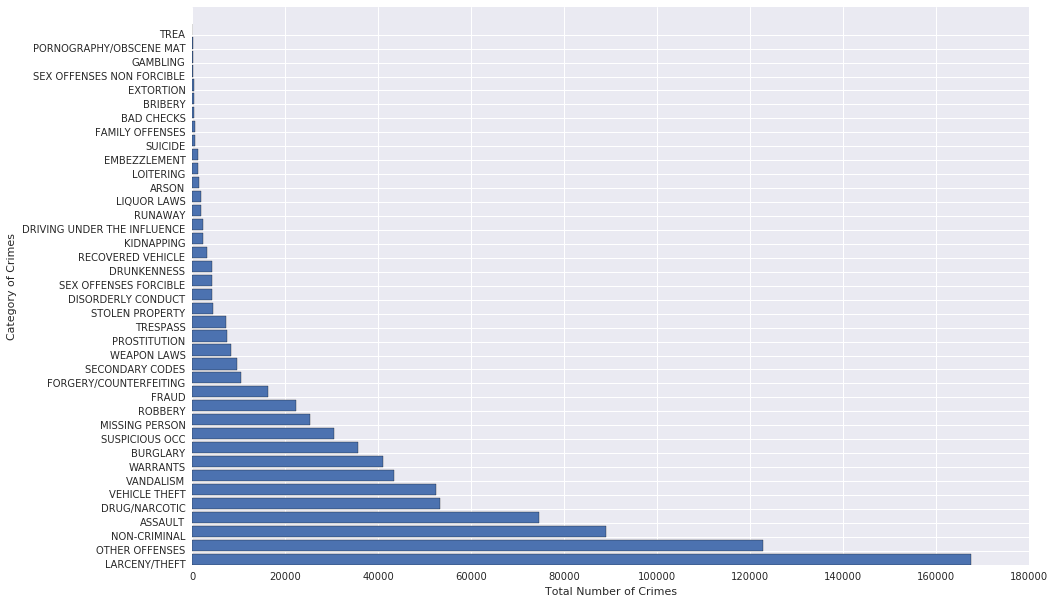

In [5]:
### Frequency per Category ###
di = df.Category.value_counts().index 
dv = df.Category.value_counts().values

index = np.arange(len(di))
plt.figure(figsize=(15,10))
plt.barh(index, list(dv))
plt.yticks(index, di)
plt.ylabel("Category of Crimes")
plt.xlabel("Total Number of Crimes")
plt.show()

### Group similar crime types into broader categories

- Violent Crime
    - Assault
    - Robbery
    - Sex Offense, Forcible
- Property Crime
    - Burglary
    - Vandalism
    - Larceny
    - Vehicle Theft
    - Arson
    - Stolen Property
    
- Substance Based Crime
    - Drug/Narcotic
    - Drunkenness
    - Liquor Laws Violation
    - Driving Under The Influence
    
- No Crime: False Alarm

- Other Crime


In [383]:
def map_crime_type(crime):
    """
    Violent crimes are murder and nonnegligent manslaughter, forcible rape, robbery, and aggravated assault.     
    Property crime includes the offenses of burglary, larceny-theft, motor vehicle theft, and arson.
    
    Reference:
    FBI’s Uniform Crime Reporting (UCR) Program
    https://ucr.fbi.gov/crime-in-the-u.s/2010/crime-in-the-u.s.-2010/violent-crime
    
    """
    if crime in ('ASSAULT', 'ROBBERY', 'SEX OFFENSES, FORCIBLE'):
        return 'VIOLENT CRIMES'
    elif crime in ('BURGLARY', 'VANDALISM', 'LARCENY/THEFT', 'VEHICLE THEFT', 'ARSON', 'STOLEN PROPERTY'):
        return 'PROPERTY CRIMES'
    elif crime in ('DRUG/NARCOTIC', 'DRUNKENNESS', 'LIQUOR LAWS', 'DRIVING UNDER THE INFLUENCE'):
        return 'SUBSTANCE-BASED CRIMES'
    elif crime in ('NON-CRIMINAL'):
        return 'NO CRIMES'
    else:
        return 'OTHER CRIMES'

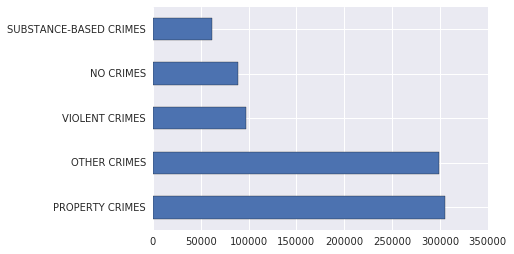

In [384]:
df.Category.apply(map_crime_type).value_counts().plot(kind='barh')

In [385]:
## Group Crime Categories into Groups ##
df['Crime_Type'] = df.Category.apply(map_crime_type)

### Look at Crime Pattern in general

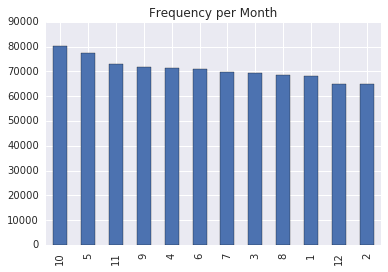

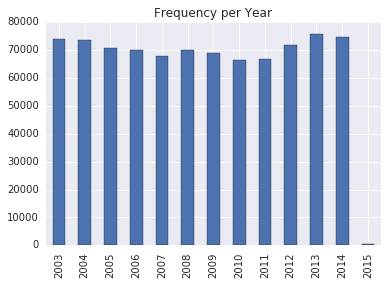

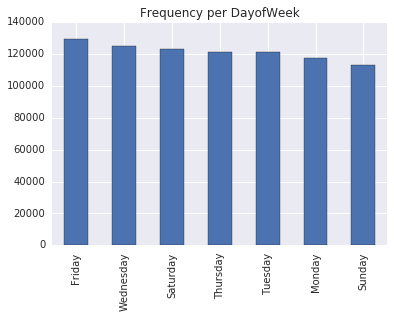

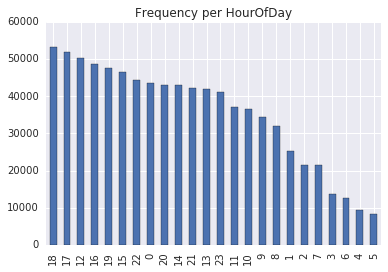

In [6]:
### Frequency per Month ###
df.Month.value_counts().plot(kind='bar')
plt.title("Frequency per Month")
plt.show()

### Frequency per Year ###
df.Dates.map(lambda x: x.year).value_counts().sort_index().plot(kind='bar')
plt.title("Frequency per Year")
plt.show()

### Frequency per DayofWeek ###
df.DayOfWeek.value_counts().plot(kind='bar')
plt.title("Frequency per DayofWeek")
plt.show()

### Frequency per Hour of the Day ###
df.HourOfDay.value_counts().plot(kind='bar')
plt.title("Frequency per HourOfDay")
plt.show()

### Explore how different type of crimes "behave" differently

In [8]:
def barplot_facet_grid(df, facet_on, xticks, facet_var, figsize=(6, 18), orient='v'):
    """
    Plot Levels based on differenct ways to facet the data.
    xticks: a list of labels on x axis
    facet_var: feature name string, the feature to facet upon, e.g. 'DayOfWeek'
    """
    if orient == 'v':
        facet_var_x, facet_var_y = facet_var, None
    elif orient == 'h':
        facet_var_x, facet_var_y = None, facet_var
    else:
        raise("Wrong argument value for orient: 'v' or 'h'")
        
    facet_vals = df[facet_on].unique()
    f, axs = plt.subplots(len(facet_vals), 1, figsize=figsize, sharex=True)

    for ax, facet_val in zip(axs, facet_vals):
        sns.countplot(x=facet_var_x, y=facet_var_y, data=df[df[facet_on] == facet_val], palette="BuGn_d", ax=ax, order=xticks)
        ax.set(ylabel=facet_val)


    # Finalize the plot
    sns.despine(bottom=True)
    plt.xticks(range(0,len(xticks)), xticks)
    plt.tight_layout(h_pad=5)

#### Different crimes have different weekday patterns

- Violent and Property Crime peak at Friday and Saturday, yet Substance-based crimes mostly happen from Tuesday to Thursday.

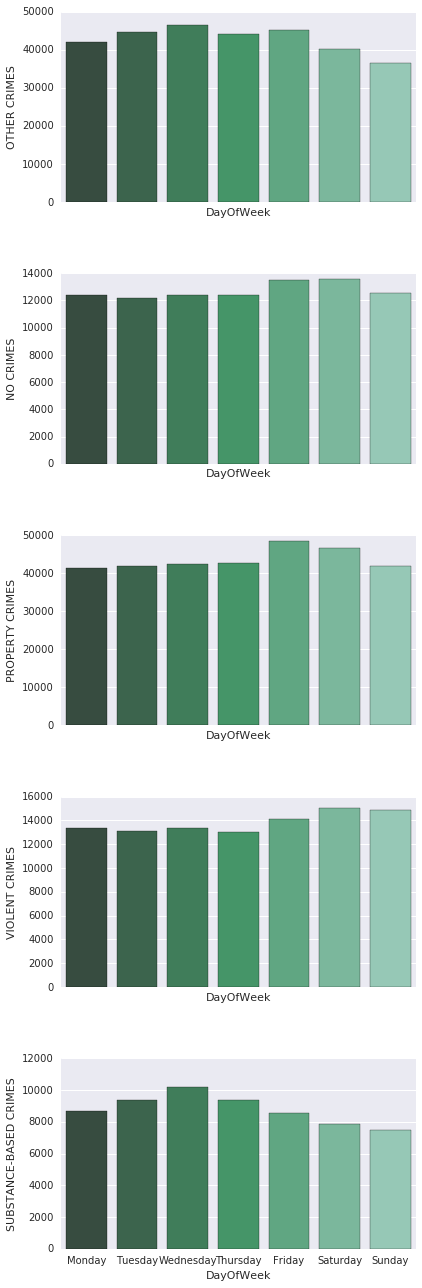

In [9]:
##
## different crimes have different weekday patterns
## 
days_of_week = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
barplot_facet_grid(df, 'Crime_Type', days_of_week, 'DayOfWeek')

#### different crimes have different hour of day patterns

- 12 PM is the peak for all the crime types, which makes sense as it's the time where most people are out!
- Property crimes climb around 5 pm - 8 pm
- Violent crimes mostly happen around midnight
- Substance based crimes mostly happen in the afternoon 1 pm - 7 pm.

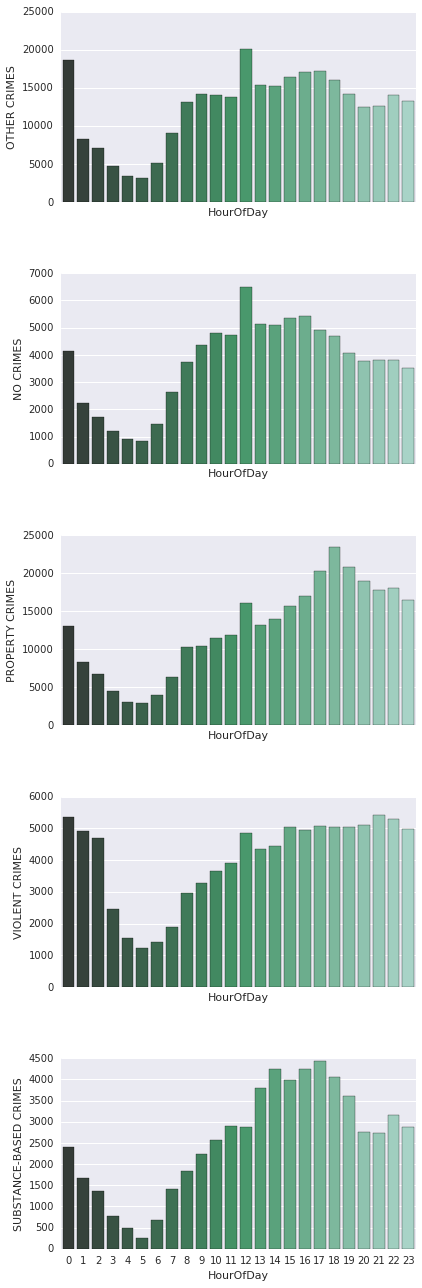

In [389]:
#
# different crimes have different hour of day patterns
# 
hours_of_day = range(24)
barplot_facet_grid(df, 'Crime_Type', hours_of_day, 'HourOfDay')

#### different crimes have different monthly patterns

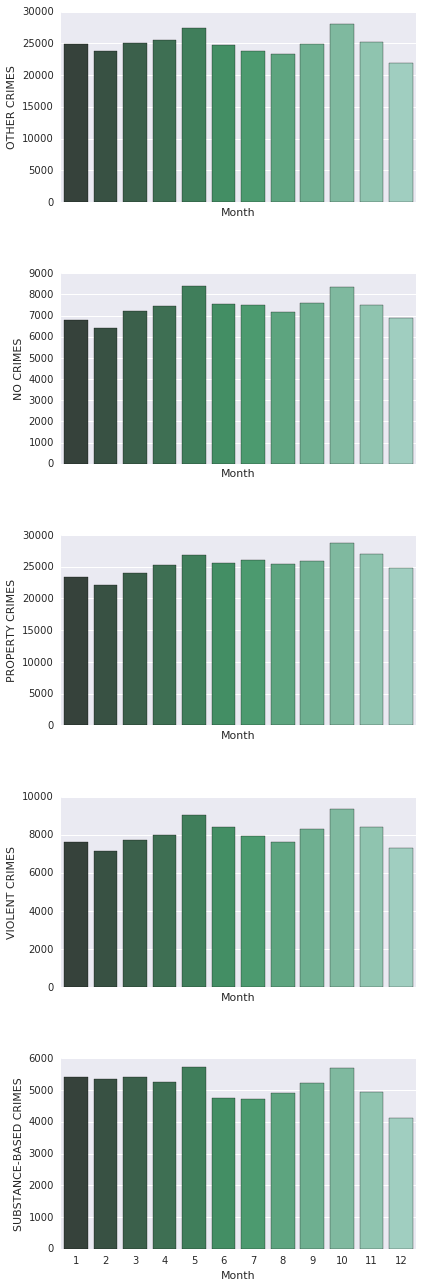

In [391]:
##
## different crimes have different monthly patterns
## 
months = range(1,13)
barplot_facet_grid(df, 'Crime_Type', months, 'Month')

#### different crimes have different neighborhood patterns

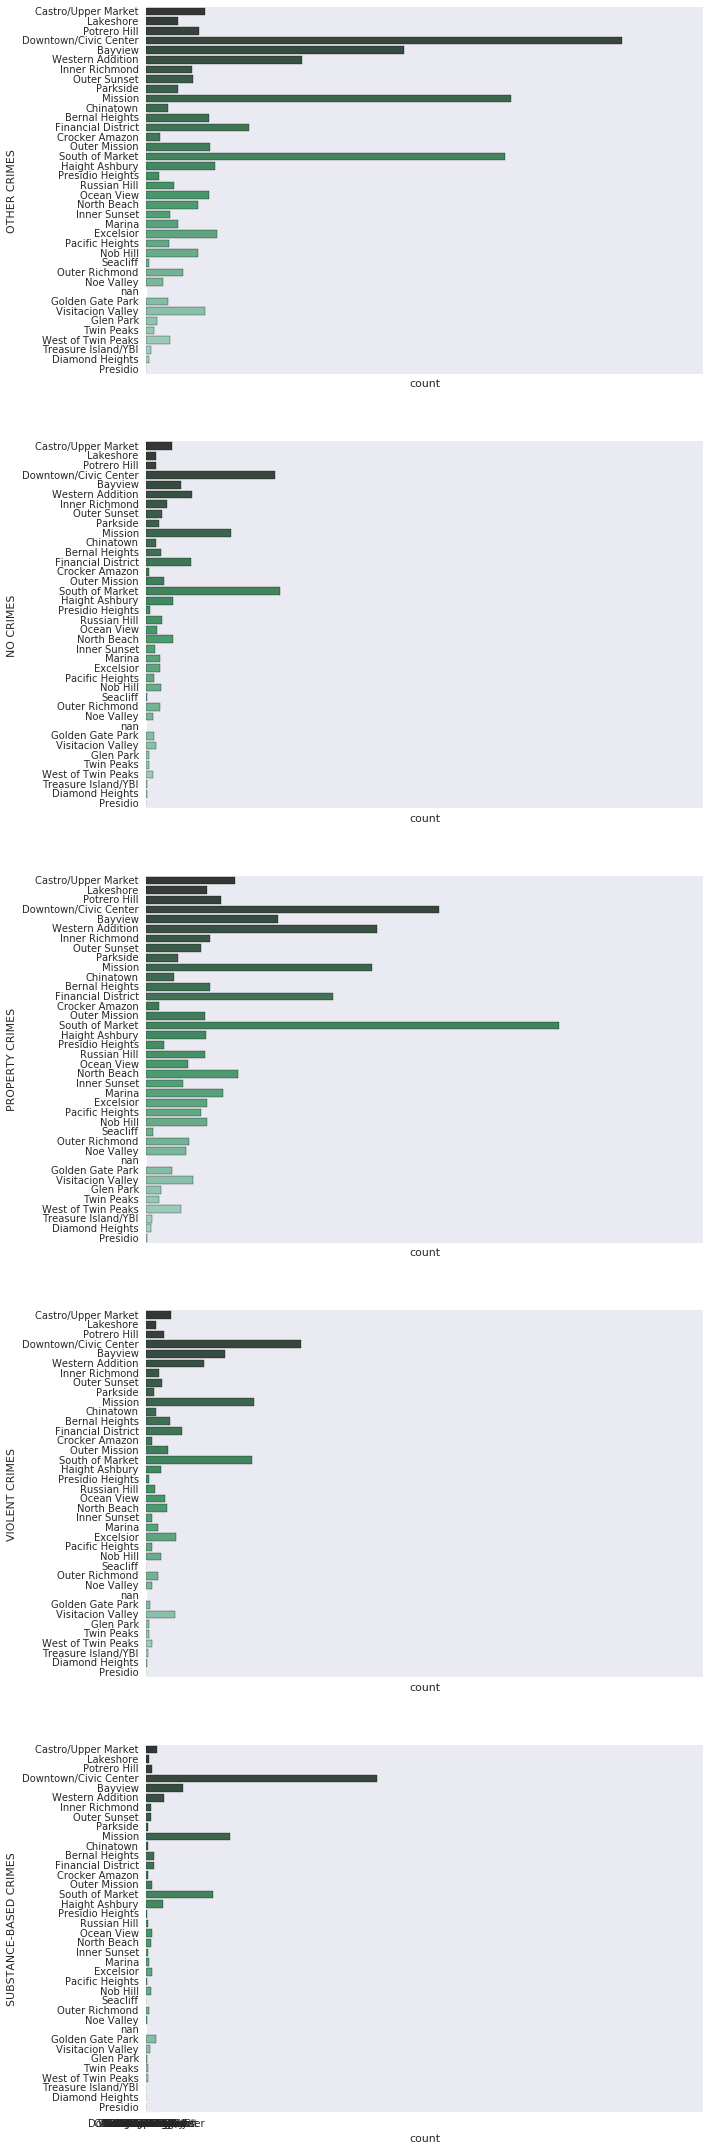

In [395]:
barplot_facet_grid(df, 'Crime_Type', df.shape_neighborhood.unique(), 'shape_neighborhood', figsize=(10, 30), orient='h')

### Data Modelling

#### Predicting the type of crime is a multi-class classification problem. First, I tried using Random Forest, which inherently supports multi-class classification.

In [10]:
def dummify(df, list_of_variables, del_prams = False):
    """
    first element is your data frame
    second element is the list of all varaibles you would like to make dummy variables for
    third element is False as default. If it is true it will delete the original variable that you create 
    dummy variables for
    """
    for i in list_of_variables:
        vars()[i + '_dummy'] = pd.get_dummies(df[i], prefix = i)
        print("Base level:", (vars()[i + '_dummy']).columns.values[0])
        del vars()[i + '_dummy'][(vars()[i + '_dummy']).columns.values[0]]       
        df = pd.concat([df, vars()[i + '_dummy']], axis=1)
        
        if del_prams == True:
            del df[i]
                        
    return df

In [30]:
x_columns = ['DayOfWeek', 'shape_neighborhood', 'HourOfDay', 'Month']
X = df[x_columns]
y = df['Crime_Type'] 

X = dummify(X, x_columns, del_prams=True)

('Base level:', 'DayOfWeek_Friday')
('Base level:', 'shape_neighborhood_Bayview')
('Base level:', 'HourOfDay_0')
('Base level:', 'Month_1')


In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=24)

In [32]:
from sklearn.ensemble import RandomForestClassifier

def seek_opt_random_forest(X, y, max_features_range, class_weight = None):
    """
    Use OOB score to find the optimal RF model.
    class_weigth: 'balanced' or None
    """
    oob_scores = []    
    rf_models = []
    for mf in max_features_range:
        RFClass = RandomForestClassifier(n_estimators = 1000, 
                                         max_features = mf, # You can set it to a number or 'sqrt', 'log2', etc
                                         min_samples_leaf = 10,
                                         oob_score = True,
                                         class_weight = class_weight,
                                         random_state = 1,
                                         n_jobs = -1)

        RFClass.fit(X, y)
        oob_scores.append(RFClass.oob_score_)
        rf_models.append(RFClass)
        print("Out of Bag Accuracy  = %f when max_features = %f" % (RFClass.oob_score_, mf))
        
        
    return [oob_scores, rf_models]

Out of Bag Accuracy  = 0.430731 when max_features = 6.000000
Out of Bag Accuracy  = 0.431238 when max_features = 7.000000
Out of Bag Accuracy  = 0.431343 when max_features = 8.000000
Out of Bag Accuracy  = 0.431822 when max_features = 9.000000
Out of Bag Accuracy  = 0.431545 when max_features = 10.000000
Out of Bag Accuracy  = 0.431829 when max_features = 11.000000


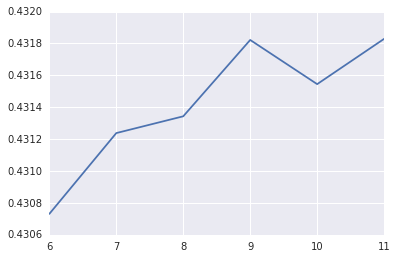

Our optimal Max Feature is 11.000000
Our accuracy at optimal C is 0.431829


In [35]:
max_features_range = range(6, 12)
oob_scores, rf_models = seek_opt_random_forest(X_train, y_train, max_features_range)

plt.plot(max_features_range, oob_scores)
plt.show()

print("Our optimal Max Feature is %f" % max_features_range[np.argmax(oob_scores)])   
print("Our accuracy at optimal C is %f" % np.max(oob_scores))

Out of Bag Accuracy  = 0.431829 when max_features = 11.000000
Out of Bag Accuracy  = 0.431536 when max_features = 12.000000
Out of Bag Accuracy  = 0.431645 when max_features = 13.000000
Out of Bag Accuracy  = 0.431385 when max_features = 14.000000


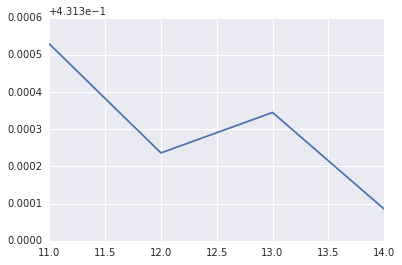

Our optimal Max Feature is 11.000000
Our accuracy at optimal C is 0.431829


In [36]:
max_features_range = range(11, 15)
oob_scores, rf_models = seek_opt_random_forest(X_train, y_train, max_features_range)

plt.plot(max_features_range, oob_scores)
plt.show()

print("Our optimal Max Feature is %f" % max_features_range[np.argmax(oob_scores)])   
print("Our accuracy at optimal C is %f" % np.max(oob_scores))

In [37]:
RFClass = rf_models[0] 
RFClass.oob_score_

0.43182914444177445

### Rank the Feature Importance

- Neighborhood features such as Downtown/Civic Center, and Mission stand out, which is not surprising
- Day of week is a pretty important predictor as well. 

Limit of Random Forest: we want to know how big the impact is of each important feature, as well as the "direction" of it. For example, Monday stands out as a very important feature, but does it actually increase, or decrease the chance of crime? And which type of crime?

In [38]:
from pprint import pprint
pprint(sorted(list(zip(X_train.columns, RFClass.feature_importances_)), key=lambda x: x[1], reverse=True))

[('shape_neighborhood_Downtown/Civic Center', 0.090069293377231519),
 ('DayOfWeek_Monday', 0.032928526807102884),
 ('shape_neighborhood_Mission', 0.031802258808202373),
 ('DayOfWeek_Thursday', 0.031720648158387856),
 ('DayOfWeek_Tuesday', 0.030128912881628209),
 ('DayOfWeek_Wednesday', 0.029019453450188793),
 ('Month_5', 0.025688714327933307),
 ('Month_10', 0.025481363257282223),
 ('DayOfWeek_Saturday', 0.025241191626487067),
 ('Month_6', 0.02516637954147424),
 ('Month_9', 0.025050296485299554),
 ('Month_11', 0.025037596682202245),
 ('Month_4', 0.024746568039357784),
 ('Month_8', 0.02472553101739873),
 ('Month_3', 0.024525959399053335),
 ('Month_7', 0.024309194778599476),
 ('DayOfWeek_Sunday', 0.02372591174372421),
 ('Month_12', 0.022950985838713214),
 ('Month_2', 0.022292949301799359),
 ('shape_neighborhood_Financial District', 0.020821710410009811),
 ('shape_neighborhood_Marina', 0.016237433767458495),
 ('HourOfDay_18', 0.014688750099519973),
 ('shape_neighborhood_Pacific Heights', 0

In [40]:
from sklearn.metrics import confusion_matrix
y_hat = RFClass.predict(X_test)
confmat = confusion_matrix(y_test, y_hat)

In [41]:
def plot_confusion_matrix(cm, ticks, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.figure(figsize=(15,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(ticks))
    plt.xticks(tick_marks, ticks, rotation=45)
    plt.yticks(tick_marks, ticks)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

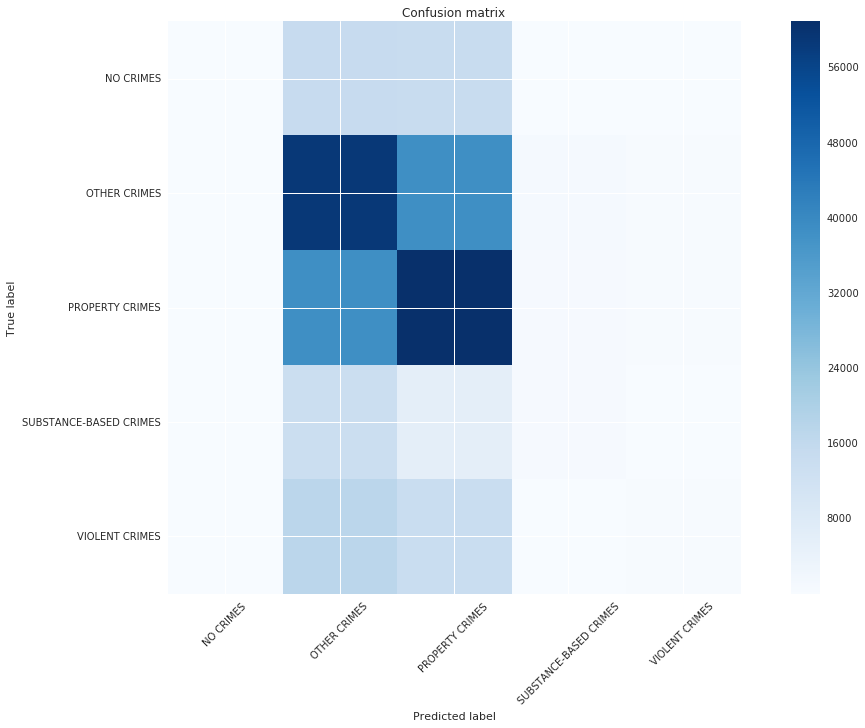

In [42]:
plot_confusion_matrix(confmat, np.unique(y_test))

### Use One-vs-All approach


To make our model more interpretable, I chose one-vs-all approach to break down each type of crime one by one. This will enable us to analyze each type of crime and understand how the predictors impact it.

Also, I used undersampling and oversampling techniques to balance out the data in the face of rarer crimes.

In [26]:
def return_one_vs_all_training(dataframe,
                               crime_type, 
                               crime_column='Crime_Type',                              
                               resample=False,
                               x_columns=['DayOfWeek', 'shape_neighborhood', 'HourOfDay', 'Month']):
    
    df = dataframe.copy()
    
    df['Crime_Type_Code'] = 1 # negative case
    df['Crime_Type_Code'][df[crime_column] == crime_type] = 0 # positive case 
    
    if resample:         
        df_other = df[df.Crime_Type_Code == 1]
        df_one = df[df.Crime_Type_Code == 0]
        len_other = len(df_other)
        len_one = len(df_one)
        
        if len_other > len_one:       
            df_other = df_other.sample(frac=1.0*len_one/len_other, replace=False)
        elif len_other < len_one:
            df_other = df_other.sample(frac=1.0*len_one/len_other, replace=True)
    
        df = pd.concat([df_one, df_other], axis=0).reset_index()
            
    X = df[x_columns]
    X = dummify(X, x_columns, del_prams=True)
    y = df['Crime_Type_Code'] 
    return (X, y)

In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import cross_val_score
def tune_logistic_regression(X, y, 
                             cv=5, 
                             max_iter=1000,
                             scoring='accuracy', 
                             n_jobs=-1, 
                             c_list=np.logspace(-5,5,11), c_index=np.linspace(-5,5,11)):

    # C is just the inverse of Lambda - the smaller the C - the stronger the
    # regulatization. The smaller C's choose less variables
    cv_scores = []
    for c_score in c_list:
        lm = LogisticRegression(C=c_score, 
                                solver='liblinear', 
                                max_iter=max_iter,                                
                                penalty='l1')
        cv_scores.append(cross_val_score(lm, X, y, cv=cv, scoring=scoring, n_jobs=n_jobs).mean())

    plt.plot(c_index, cv_scores)
    plt.show()

    print("Optimal C is %f" % c_list[np.argmax(cv_scores)])   
    print("Accuracy at optimal C is %f" % np.max(cv_scores))

### Analyzing the tuning results 
From the accuracy vs C plot we can see for four classifiers, when C gets big enough the performance doesn't change that much. 

Performance (i.e. predictability) wise, regularization doesn't help that much;

However it might help us interpret the model better (with less variables).

*** PROPERTY CRIMES ***
Base rate for PROPERTY CRIMES is 0.358254
('Base level:', 'DayOfWeek_Friday')
('Base level:', 'shape_neighborhood_Bayview')
('Base level:', 'HourOfDay_0')
('Base level:', 'Month_1')


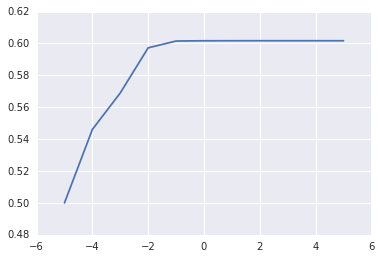

Optimal C is 100.000000
Accuracy at optimal C is 0.601735
*** OTHER CRIMES ***
Base rate for OTHER CRIMES is 0.351094
('Base level:', 'DayOfWeek_Friday')
('Base level:', 'shape_neighborhood_Bayview')
('Base level:', 'HourOfDay_0')
('Base level:', 'Month_1')


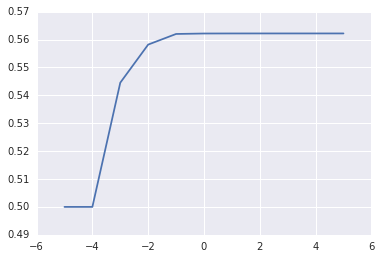

Optimal C is 1000.000000
Accuracy at optimal C is 0.562172
*** VIOLENT CRIMES ***
Base rate for VIOLENT CRIMES is 0.113850
('Base level:', 'DayOfWeek_Friday')
('Base level:', 'shape_neighborhood_Bayview')
('Base level:', 'HourOfDay_0')
('Base level:', 'Month_1')


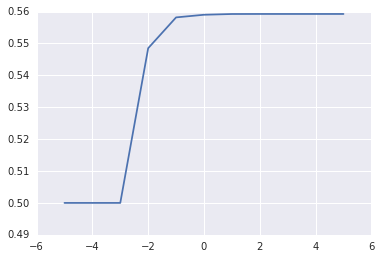

Optimal C is 100.000000
Accuracy at optimal C is 0.559260
*** NO CRIMES ***
Base rate for NO CRIMES is 0.104540
('Base level:', 'DayOfWeek_Friday')
('Base level:', 'shape_neighborhood_Bayview')
('Base level:', 'HourOfDay_0')
('Base level:', 'Month_1')


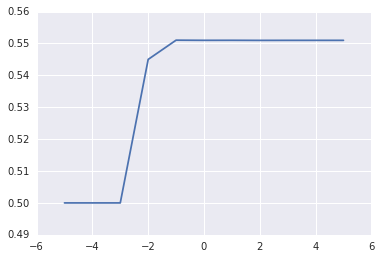

Optimal C is 0.100000
Accuracy at optimal C is 0.551036
*** SUBSTANCE-BASED CRIMES ***
Base rate for SUBSTANCE-BASED CRIMES is 0.072261
('Base level:', 'DayOfWeek_Friday')
('Base level:', 'shape_neighborhood_Bayview')
('Base level:', 'HourOfDay_0')
('Base level:', 'Month_1')


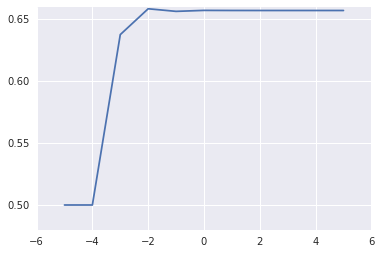

Optimal C is 0.010000
Accuracy at optimal C is 0.658248


In [15]:
pd.options.mode.chained_assignment = None
y_ct = df.Crime_Type.value_counts()

for crime_type in y_ct.index:
    print('*** %s ***' % crime_type)    
    print("Base rate for %s is %f" % (crime_type, 1.0*y_ct.loc[crime_type]/len(df)))
    X, y = return_one_vs_all_training(df, crime_type, resample=True) 
    tune_logistic_regression(X, y)

## Evaluate and Interpret Each Classifier 

In [16]:
from pprint import pprint
from sklearn.metrics import roc_curve, auc,roc_auc_score

def finalize_the_classification_result(dataframe, crime_type, optimal_C, resample=True):
    """
    Use the optimal C and fit the classifier.
    Print out the coefficients, and plot the ROC curve.
    """
    df = dataframe.copy()
    X, y = return_one_vs_all_training(df, crime_type, resample=resample) 
    lm = LogisticRegression(C=C,  solver='liblinear', max_iter=10000, penalty='l1')
    lm.fit(X, y)
    
    # Now zip name of variables and your coefficients
    var_coef = sorted(zip(lm.coef_[0,:], X.columns.values), key=lambda x:x[0], reverse=True)
    print('*'*20)
    print("*** Coefficients for %s classifier ***" % crime_type)
    pprint(var_coef)

    y_hat_probability = lm.predict_proba(X).T[1]  #T[1] returns probability of belonging to class
    auc = roc_auc_score(y, y_hat_probability)
    vals = roc_curve(y, y_hat_probability) 

    #######################
    # Plot of a ROC curve 
    plt.figure()
    plt.plot(vals[0], vals[1], label='ROC curve (area = %0.2f)' % auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic for %s classifier' % crime_type)
    plt.legend(loc="lower right")
    plt.show()


*** SUBSTANCE-BASED CRIMES ***
('Base level:', 'DayOfWeek_Friday')
('Base level:', 'shape_neighborhood_Bayview')
('Base level:', 'HourOfDay_0')
('Base level:', 'Month_1')
********************
*** Coefficients for SUBSTANCE-BASED CRIMES classifier ***
[(0.47652392522435977, 'shape_neighborhood_Financial District'),
 (0.35456722752175096, 'shape_neighborhood_Pacific Heights'),
 (0.34506096671104641, 'HourOfDay_5'),
 (0.32014285972292528, 'shape_neighborhood_Marina'),
 (0.17464462923235785, 'shape_neighborhood_Russian Hill'),
 (0.15941133913286309, 'HourOfDay_8'),
 (0.15037618588054236, 'shape_neighborhood_Lakeshore'),
 (0.13056251087536469, 'HourOfDay_12'),
 (0.11050316350952273, 'shape_neighborhood_North Beach'),
 (0.10165381083888692, 'Month_12'),
 (0.093082199080990066, 'shape_neighborhood_Western Addition'),
 (0.08569170373830938, 'DayOfWeek_Saturday'),
 (0.07747790276212603, 'shape_neighborhood_Visitacion Valley'),
 (0.053332000475549944, 'shape_neighborhood_Outer Richmond'),
 (0.04

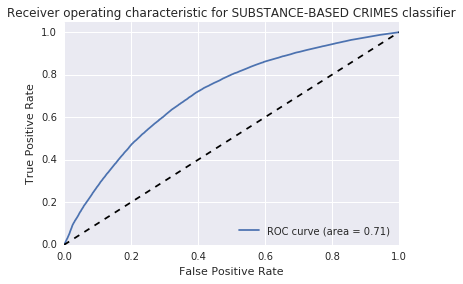

*** VIOLENT CRIMES ***
('Base level:', 'DayOfWeek_Friday')
('Base level:', 'shape_neighborhood_Bayview')
('Base level:', 'HourOfDay_0')
('Base level:', 'Month_1')
********************
*** Coefficients for VIOLENT CRIMES classifier ***
[(1.0070577007903558, 'shape_neighborhood_Seacliff'),
 (0.95291867405351482, 'shape_neighborhood_Golden Gate Park'),
 (0.85371702750111855, 'shape_neighborhood_Pacific Heights'),
 (0.66837400811569958, 'shape_neighborhood_Haight Ashbury'),
 (0.65089143356799106, 'shape_neighborhood_Russian Hill'),
 (0.57825199229919499, 'shape_neighborhood_Marina'),
 (0.54182072101727285, 'shape_neighborhood_Inner Richmond'),
 (0.54115960576186961, 'shape_neighborhood_Lakeshore'),
 (0.51784078709337289, 'shape_neighborhood_Noe Valley'),
 (0.51684118607841634, 'shape_neighborhood_Presidio Heights'),
 (0.49535497846581089, 'shape_neighborhood_Inner Sunset'),
 (0.49287984755933589, 'shape_neighborhood_West of Twin Peaks'),
 (0.45568571128316576, 'shape_neighborhood_Nob Hill'

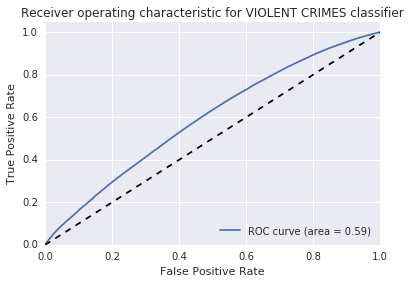

*** NO CRIMES ***
('Base level:', 'DayOfWeek_Friday')
('Base level:', 'shape_neighborhood_Bayview')
('Base level:', 'HourOfDay_0')
('Base level:', 'Month_1')
********************
*** Coefficients for NO CRIMES classifier ***
[(0.20487390447538403, 'HourOfDay_2'),
 (0.14798721801634263, 'HourOfDay_23'),
 (0.14291305172392613, 'HourOfDay_1'),
 (0.14075603879235343, 'shape_neighborhood_Potrero Hill'),
 (0.13300912245663132, 'HourOfDay_19'),
 (0.11409014190062615, 'HourOfDay_3'),
 (0.10355799076383415, 'HourOfDay_20'),
 (0.10259262263800362, 'HourOfDay_18'),
 (0.099808388731870701, 'HourOfDay_22'),
 (0.065798039570793096, 'DayOfWeek_Wednesday'),
 (0.063505743897730296, 'HourOfDay_21'),
 (0.03359710321678909, 'DayOfWeek_Tuesday'),
 (0.030404666942631487, 'shape_neighborhood_Visitacion Valley'),
 (0.024383303061495529, 'DayOfWeek_Thursday'),
 (0.023485965400321267, 'HourOfDay_17'),
 (0.016236367831805695, 'Month_2'),
 (0.0, 'DayOfWeek_Monday'),
 (0.0, 'HourOfDay_4'),
 (-0.0027506625116644392

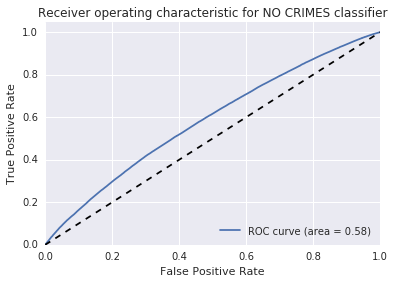

*** PROPERTY CRIMES ***
('Base level:', 'DayOfWeek_Friday')
('Base level:', 'shape_neighborhood_Bayview')
('Base level:', 'HourOfDay_0')
('Base level:', 'Month_1')
********************
*** Coefficients for PROPERTY CRIMES classifier ***
[(0.13347608631270558, 'shape_neighborhood_Downtown/Civic Center'),
 (0.10299432865782564, 'DayOfWeek_Wednesday'),
 (0.083515709312817502, 'DayOfWeek_Tuesday'),
 (0.07043583746057476, 'DayOfWeek_Thursday'),
 (0.047954906478149567, 'DayOfWeek_Monday'),
 (0.031322336352822007, 'Month_2'),
 (0.0, 'HourOfDay_9'),
 (-0.00037768833967760944, 'Month_3'),
 (-0.0036449089421815416, 'Month_5'),
 (-0.0044526311550286699, 'HourOfDay_7'),
 (-0.022681188363299257, 'DayOfWeek_Sunday'),
 (-0.036550677092858107, 'shape_neighborhood_Mission'),
 (-0.036552449983578671, 'Month_4'),
 (-0.045889766930459666, 'DayOfWeek_Saturday'),
 (-0.049698971943488011, 'Month_10'),
 (-0.058216816058773997, 'Month_6'),
 (-0.059112880597302214, 'HourOfDay_2'),
 (-0.0599425135480312, 'HourOf

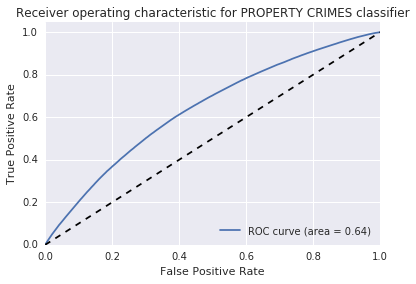

*** OTHER CRIMES ***
('Base level:', 'DayOfWeek_Friday')
('Base level:', 'shape_neighborhood_Bayview')
('Base level:', 'HourOfDay_0')
('Base level:', 'Month_1')
********************
*** Coefficients for OTHER CRIMES classifier ***
[(1.0326844126023367, 'shape_neighborhood_Marina'),
 (0.99536611070643355, 'shape_neighborhood_Noe Valley'),
 (0.9906957932361482, 'shape_neighborhood_Seacliff'),
 (0.97768151465278008, 'shape_neighborhood_Pacific Heights'),
 (0.95949760146296936, 'shape_neighborhood_Russian Hill'),
 (0.87573773781352904, 'shape_neighborhood_Diamond Heights'),
 (0.87481948014078637, 'shape_neighborhood_Financial District'),
 (0.87480519254005262, 'shape_neighborhood_North Beach'),
 (0.84066960390109613, 'shape_neighborhood_Lakeshore'),
 (0.84032476424231761, 'shape_neighborhood_Twin Peaks'),
 (0.79946003522170139, 'shape_neighborhood_Castro/Upper Market'),
 (0.70514368069854128, 'shape_neighborhood_Inner Richmond'),
 (0.7014438343825613, 'shape_neighborhood_Inner Sunset'),
 (

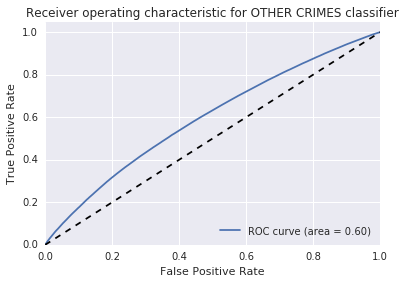

In [17]:
class_C_pairs = [
    ('SUBSTANCE-BASED CRIMES', 0.01),
    ('VIOLENT CRIMES', 0.1),
    ('NO CRIMES', 0.1),
    ('PROPERTY CRIMES', 0.1),
    ('OTHER CRIMES', 0.1),
]

for crime_type, C in class_C_pairs:
    print('*** %s ***' % crime_type)    
    finalize_the_classification_result(df, crime_type, C)

In [25]:
# import statsmodels.api as sm
# df['Intercept'] = 1
# for crime_type in df.Crime_Type.unique():
#     print('***', crime_type, '***')
#     X, y = return_one_vs_all_training(df, crime_type, resample=True, x_columns=['Intercept', 'DayOfWeek', 'shape_neighborhood', 'HourOfDay', 'Month'])
#     print(len(y))
#     logit = sm.Logit(y, X)
#     result = logit.fit()
#     print(result.summary())

### Selected result interpretation

- Using Bayview as a base level for neighborhood and holding other variables constant, a crime report happening in Financial District has 47% lower odds of being substance-based, whereas Downtown/Civic Center has 162% higher odds.
- Holding other variables constant, a crime report happening at 1 AM, 2 AM, and 3 AM has respectively 56%, 73%, 50% higher odds of being a violent crime, compared to the ones at 12 AM. The neighborhoods of Visitacion Valley and Excelsior tend to be the most dangerous ones for violent crimes.
- Presidio, Parkside, Inner Richmond, and Haight Ashbury have higher chance of reporting false alarms. 
- Property crimes tend to be more likely to happen in richer neighborhoods: Seacliff, Pacific Heights, Noe Valley, Marina, Lakeshore, and Russian Hill.